In [79]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
df_VWCE=pd.read_csv('vwce.csv')
df_SP500=pd.read_csv('sp500.csv')
df_APPLE=pd.read_csv('apple.csv')
df_MSCI=pd.read_csv('msci.csv')
df_EIMI=pd.read_csv("eimi.csv")
sns.set(style="darkgrid")

In [80]:
df_VWCE

,Date,Price,Open,High,Low,Vol.,Change %
0,03/26/2025,130.02,130.98,131.06,129.90,114.34K,-0.44%
1,03/25/2025,130.60,130.46,130.86,130.28,158.69K,0.11%
2,03/24/2025,130.46,129.60,130.62,129.40,180.45K,1.62%
3,03/21/2025,128.38,128.52,128.66,127.54,93.17K,-0.28%
4,03/20/2025,128.74,129.06,129.62,127.96,137.36K,0.22%
...,...,...,...,...,...,...,...
1330,01/08/2020,77.80,77.28,77.80,77.17,5.27K,0.27%
1331,01/07/2020,77.59,77.44,77.65,77.32,4.72K,0.64%
1332,01/06/2020,77.10,77.01,77.27,76.50,7.26K,-0.32%
1333,01/03/2020,77.35,77.22,77.57,77.00,4.67K,-0.06%


In [81]:
df_VWCE['Date']=pd.to_datetime(df_VWCE['Date'])
df_VWCE_ordered=df_VWCE.sort_values(by='Date', ascending=True).copy()
df_SP500['Date']=pd.to_datetime(df_SP500['Date'])
df_SP500_ordered=df_SP500.sort_values(by='Date', ascending=True).copy()
df_MSCI['Date']=pd.to_datetime(df_MSCI['Date'])
df_MSCI_ordered=df_MSCI.sort_values(by='Date', ascending=True).copy()
df_EIMI['Date']=pd.to_datetime(df_EIMI['Date'])
df_EIMI_ordered=df_EIMI.sort_values(by='Date', ascending=True).copy()


In [82]:
df_VWCE_ordered.set_index('Date', inplace=True)
df_SP500_ordered.set_index('Date', inplace=True)
df_MSCI_ordered.set_index('Date', inplace=True)
df_EIMI_ordered.set_index('Date', inplace=True)

Text(0, 0.5, 'Price')

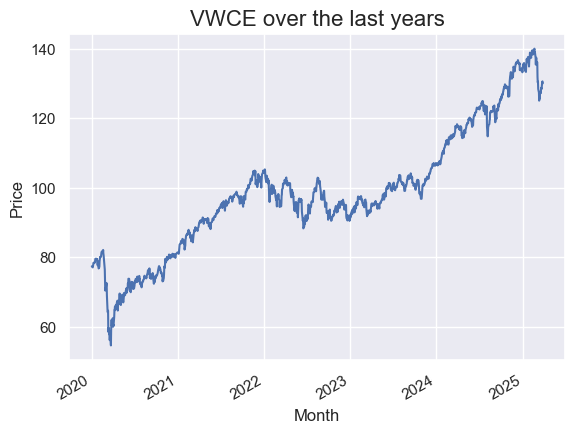

In [83]:
df_VWCE_ordered['Price'].plot(kind='line')
plt.title("VWCE over the last years", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Price", fontsize=12)


In [84]:
df_VWCE_ordered.describe()

,Price,Open,High,Low
count,1335.000000,1335.000000,1335.000000,1335.00000
mean,98.480929,98.490869,98.930105,98.00227
std,17.578626,17.576042,17.559803,17.59452
min,54.660000,54.960000,57.330000,54.00000
25%,89.965000,90.055000,90.465000,89.56000
50%,97.130000,97.050000,97.500000,96.68000
75%,104.780000,104.850000,105.050000,104.58000
max,140.000000,140.000000,140.180000,139.42000


In [85]:
df_VWCE_ordered.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1335 entries, 2020-01-02 to 2025-03-26
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     1335 non-null   float64
 1   Open      1335 non-null   float64
 2   High      1335 non-null   float64
 3   Low       1335 non-null   float64
 4   Vol.      1334 non-null   object 
 5   Change %  1335 non-null   object 
dtypes: float64(4), object(2)
memory usage: 73.0+ KB


In [86]:
df_VWCE_ordered['Change %'] = df_VWCE_ordered['Change %'].replace('%', '', regex=True)  # Remove %
df_VWCE_ordered['Change %'] = df_VWCE_ordered['Change %'].astype(float)  
df_SP500_ordered['Change %'] = df_SP500_ordered['Change %'].replace('%', '', regex=True)  # Remove %
df_SP500_ordered['Change %'] = df_SP500_ordered['Change %'].astype(float)
df_MSCI_ordered['Change %'] = df_MSCI_ordered['Change %'].replace('%', '', regex=True)  # Remove %
df_MSCI_ordered['Change %'] = df_MSCI_ordered['Change %'].astype(float)
df_EIMI_ordered['Change %'] = df_EIMI_ordered['Change %'].replace('%', '', regex=True)  # Remove %
df_EIMI_ordered['Change %'] = df_EIMI_ordered['Change %'].astype(float)

In [87]:
df_VWCE_ordered

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2020-01-02,77.40,77.22,77.76,77.22,11.37K,0.16
2020-01-03,77.35,77.22,77.57,77.00,4.67K,-0.06
2020-01-06,77.10,77.01,77.27,76.50,7.26K,-0.32
2020-01-07,77.59,77.44,77.65,77.32,4.72K,0.64
2020-01-08,77.80,77.28,77.80,77.17,5.27K,0.27
...,...,...,...,...,...,...
2025-03-20,128.74,129.06,129.62,127.96,137.36K,0.22
2025-03-21,128.38,128.52,128.66,127.54,93.17K,-0.28
2025-03-24,130.46,129.60,130.62,129.40,180.45K,1.62


In [88]:
df_VWCE_sorted=df_VWCE_ordered.sort_values(by='Change %', ascending=True)

In [89]:
# The Sp500 CSV uses ',' as separator, i need to replace it as i want a float value
columns_to_edit = ['Price', 'Open', 'High', 'Low']
for col in columns_to_edit:
    df_SP500_ordered[col] = df_SP500_ordered[col].str.replace(',', '').astype(float)

In [90]:
#Check correlation between VWCE and Sp500
df_VWCE_ordered['Price'].corr(df_SP500_ordered['Price'])

np.float64(0.9844308436898618)

In [91]:
df_MSCI_ordered

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2020-01-27,98.35,97.94,98.71,97.67,339.77K,-1.71
2020-01-28,99.26,98.70,99.51,98.60,47.28K,0.93
2020-01-29,99.29,99.51,99.72,99.12,23.53K,0.03
2020-01-30,99.44,98.57,99.45,98.38,154.06K,0.15
2020-01-31,97.73,98.94,98.94,97.58,253.55K,-1.72
...,...,...,...,...,...,...
2025-03-20,155.33,154.58,156.30,154.56,676.37K,-0.38
2025-03-21,155.23,154.23,155.35,153.84,404.16K,-0.06
2025-03-24,157.42,156.60,157.49,156.60,199.64K,1.41


In [96]:
#As i want to plot VWCE and SP500 in the same graphic to compare their performance, i need to normalize their values because they are too far
scaler=MinMaxScaler()

df_APPLE['Date']=pd.to_datetime(df_APPLE['Date'])
df_APPLE_ordered=df_APPLE.sort_values(by='Date', ascending=True).copy()
df_APPLE_ordered.set_index('Date', inplace=True)
#Let's verify the volatily of indexes and apple stocks. The best way is to use the standard deviations of the Change % 
df_APPLE_ordered['Change %'] = df_APPLE_ordered['Change %'].replace('%', '', regex=True)  # Remove %
df_APPLE_ordered['Change %'] = df_APPLE_ordered['Change %'].astype(float)

#Now i want to see if the APPLE stocks matches the indexes
df_APPLE_ordered['Normalized Price']=scaler.fit_transform(df_APPLE_ordered[['Price']])
df_VWCE_ordered['Normalized Price']=scaler.fit_transform(df_VWCE_ordered[['Price']])
df_SP500_ordered['Normalized Price']=scaler.fit_transform(df_SP500_ordered[['Price']])
df_MSCI_ordered['Normalized Price_MSCI']=scaler.fit_transform(df_MSCI_ordered[['Price']])
df_EIMI_ordered['Normalized Price']=scaler.fit_transform(df_EIMI_ordered[['Price']])

In [97]:
df_MSCI_ordered = df_MSCI_ordered.rename(columns={'Normalized Price': 'Normalized Price_MSCI'})
df_merged = df_VWCE_ordered[['Normalized Price']].merge(df_SP500_ordered[['Normalized Price']], left_index=True, right_index=True, suffixes=('_VWCE', '_SP500'))
df_merged = df_merged.merge(df_MSCI_ordered[['Normalized Price_MSCI']], left_index=True, right_index=True)
df_merged = df_merged.merge(df_APPLE_ordered[['Normalized Price']], left_index=True, right_index=True)

df_MSCI_ordered = df_MSCI_ordered.rename(columns={'Price': 'Price_MSCI'})
df_merged2 = df_VWCE_ordered[['Price']].merge(df_SP500_ordered[['Price']], left_index=True, right_index=True, suffixes=('_VWCE', '_SP500'))
df_merged2 = df_merged2.merge(df_MSCI_ordered[['Price_MSCI']], left_index=True, right_index=True)
df_merged2 = df_merged2.merge(df_APPLE_ordered[['Price']], left_index=True, right_index=True)

Text(0, 0.5, 'Price SP500')

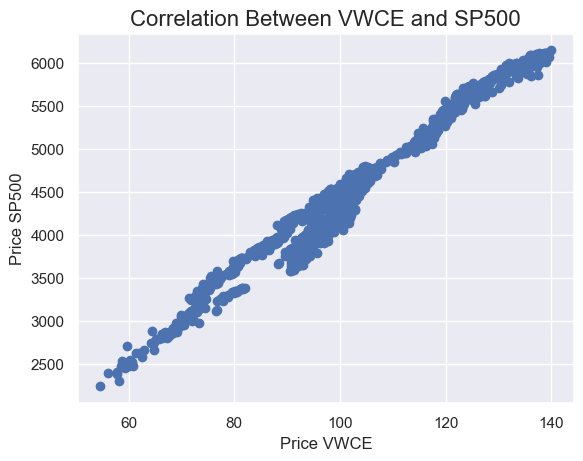

In [98]:
plt.scatter(df_merged2['Price_VWCE'], df_merged2['Price_SP500'])
plt.title("Correlation Between VWCE and SP500", fontsize=16)
plt.xlabel("Price VWCE", fontsize=12)
plt.ylabel("Price SP500", fontsize=12)
#As the result of the concentration of US stocks in FTSE-All World, we can see a nearly perfect positive correlation

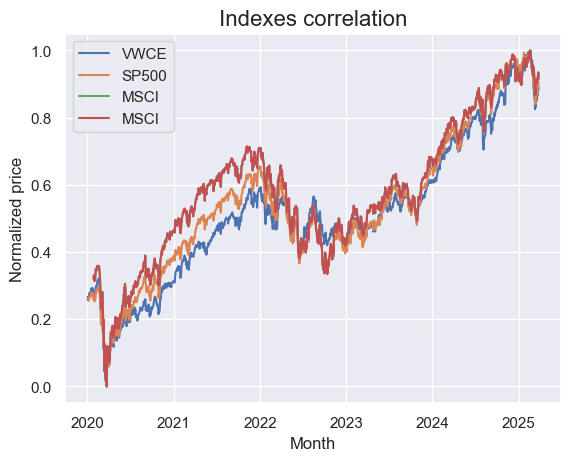

In [ ]:

plt.plot(df_VWCE_ordered.index, df_VWCE_ordered['Normalized Price'], label="VWCE")
plt.plot(df_SP500_ordered.index, df_SP500_ordered['Normalized Price'], label="SP500")
plt.plot(df_MSCI_ordered.index, df_MSCI_ordered['Normalized Price_MSCI'], label="MSCI")
plt.title("Indexes correlation", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Normalized price", fontsize=12)
plt.legend()
plt.show()

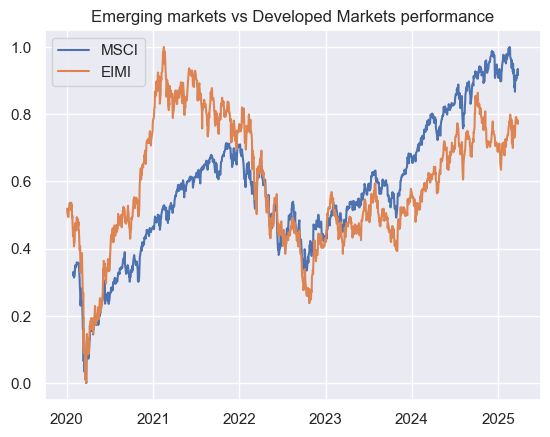

In [ ]:
#Looking at emerging markets and developed markets correlation: they are very correlated but EIMI has more volatility.
#  Are we really diversifing? The rule is to invest in different countries, but what if they move the same?

plt.plot(df_MSCI_ordered.index, df_MSCI_ordered['Normalized Price_MSCI'], label="MSCI")
plt.plot(df_EIMI_ordered.index, df_EIMI_ordered['Normalized Price'], label="EIMI")
plt.title("Emerging markets vs Developed Markets performance")
plt.legend()
plt.show()

In [ ]:
df_merged

,Normalized Price_VWCE,Normalized Price_SP500,Normalized Price_MSCI
Date,,,
2023-03-01,0.000000,0.000000,0.012719
2023-04-01,0.011366,0.031156,0.060868
2023-05-01,0.061378,0.036516,0.033841
2023-06-01,0.138668,0.176609,0.168294
2023-07-01,0.203001,0.248366,0.259596
2023-08-01,0.177540,0.206269,0.195094
2023-09-01,0.144351,0.092553,0.069498
2023-10-01,0.060923,0.043750,0.000000
2023-11-01,0.187543,0.237410,0.242335


<Axes: >

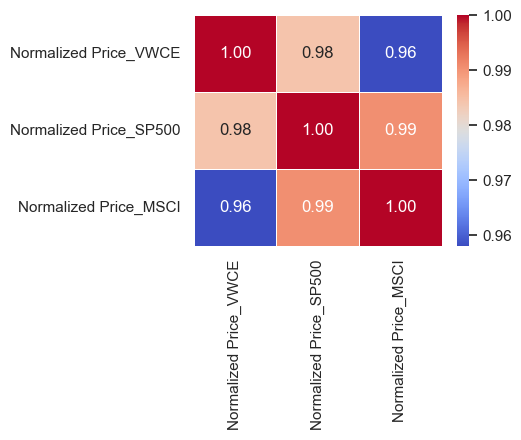

In [ ]:
#Heat map confirms the correlation between indexes

corr_matrix = df_merged[['Normalized Price_VWCE', 'Normalized Price_SP500', 'Normalized Price_MSCI']].corr()
plt.figure(figsize=(4, 3)) 
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

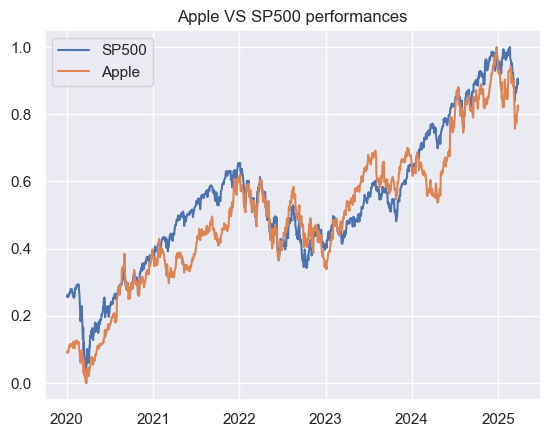

In [ ]:
plt.plot(df_SP500_ordered.index, df_SP500_ordered['Normalized Price'], label="SP500")
plt.plot(df_APPLE_ordered.index, df_APPLE_ordered['Normalized Price'], label="Apple")
plt.title("Apple VS SP500 performances")
plt.legend()
plt.show()

#The graphic shows Apple matches the index most of the time, with highter volatily. The stocks clearly suffers (and enjoys, depend of the result) the quarterly earnings.

In [ ]:
VWCE_volatility = df_VWCE_ordered['Change %'].std()
SP500_volatility = df_SP500_ordered['Change %'].std()
APPLE_volatility = df_APPLE_ordered['Change %'].std()
MSCI_volatility = df_MSCI_ordered['Change %'].std()

In [ ]:
print(VWCE_volatility,MSCI_volatility,SP500_volatility,APPLE_volatility)
#We can clearly see the volatily of the apple stock is more than the double of VWCE ande almost double of SP500/MSCI. This happens beacuse the all world ETF is less concentrated in big tech stocks
#VWCE has less returns but also less volatility, resulting a good product for risk-averse people.

1.0436823585697312 1.2684774544595159 1.33151411053487 1.988734384788778


Slope (m): [0.02365335]
Intercept (b): 20.44813654077457
(R^2): 0.9810527396975216


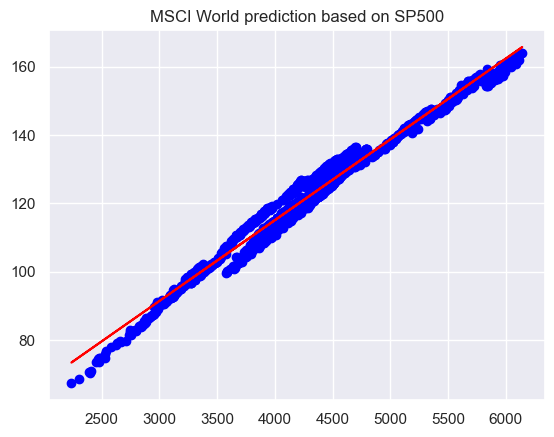

In [ ]:
#Let's doing some prediction using a linear regression. We can predict the MSCI world price using the SP500's one.

x = df_merged2[['Price_SP500']]  
y = df_merged2['Price_MSCI']   

model = LinearRegression()
model.fit(x, y)
print(f"Slope (m): {model.coef_}")
print(f"Intercept (b): {model.intercept_}")

y_pred = model.predict(x)

r2_score = model.score(x, y)
print(f"(R^2): {r2_score}")
plt.scatter(x, y, color='blue', label='Data') 
plt.plot(x, y_pred, color='red', label='Regression')
plt.title('MSCI World prediction based on SP500')
plt.show()

In [ ]:
new_sp500_price = 5770  # new SP500 price
predicted_msc_price = model.coef_ * new_sp500_price + model.intercept_
print(f"Predicted price for MSCI World = {new_sp500_price} è: {predicted_msc_price}")

Predicted price for MSCI World = 5770 è: [155.57665108]


In [ ]:
#Frokm sp500 to apple stock prediction
new_sp500 = np.array([5770]).reshape(-1, 1)
new_sp500_poly = poly.transform(new_sp500)
predicted_apple_price = model_poly.predict(new_sp500_poly)
print(predicted_apple_price)

[225.30065273]


In [ ]:
#Some deep learning: MLP

X = df_merged2[['Price_VWCE', 'Price_SP500']].values  # Input
y = df_merged2['Price_MSCI'].values  # Target 

# Convert to tensor
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)  # Target deve essere una colonna

class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(2, 64)  #input
        self.fc2 = nn.Linear(64, 32)  #hidden layer
        self.fc3 = nn.Linear(32, 1)   # Un output

    def forward(self, x):
        x = torch.relu(self.fc1(x)) 
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
model = SimpleModel()

# Loss and optimization function
criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
epochs = 5000

for epoch in range(epochs):
    model.train()
    
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)

    # Backpropagation and optiomization
    optimizer.zero_grad()  
    loss.backward()  
    optimizer.step() 

    if (epoch + 1) % 100 == 0:  # print loss value
        print(f'Epoca [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

prezzo1_input = 130.6
prezzo2_input = 5776.25


input_data = torch.tensor([[prezzo1_input, prezzo2_input]], dtype=torch.float32)

#prediction
model.eval() 
predizione = model(input_data)

print(f"Predizione: {predizione.item():.2f}")

Epoca [100/5000], Loss: 21.8698
Epoca [200/5000], Loss: 21.5877
Epoca [300/5000], Loss: 21.5802
Epoca [400/5000], Loss: 21.5710
Epoca [500/5000], Loss: 21.5603
Epoca [600/5000], Loss: 21.5482
Epoca [700/5000], Loss: 21.5346
Epoca [800/5000], Loss: 21.5197
Epoca [900/5000], Loss: 21.5034
Epoca [1000/5000], Loss: 21.4857
Epoca [1100/5000], Loss: 21.4665
Epoca [1200/5000], Loss: 21.4459
Epoca [1300/5000], Loss: 21.4238
Epoca [1400/5000], Loss: 21.4001
Epoca [1500/5000], Loss: 21.3749
Epoca [1600/5000], Loss: 21.3481
Epoca [1700/5000], Loss: 21.3196
Epoca [1800/5000], Loss: 21.2893
Epoca [1900/5000], Loss: 21.2573
Epoca [2000/5000], Loss: 21.2235
Epoca [2100/5000], Loss: 21.1877
Epoca [2200/5000], Loss: 21.1500
Epoca [2300/5000], Loss: 21.1103
Epoca [2400/5000], Loss: 21.0683
Epoca [2500/5000], Loss: 21.0242
Epoca [2600/5000], Loss: 20.9779
Epoca [2700/5000], Loss: 20.9292
Epoca [2800/5000], Loss: 20.8780
Epoca [2900/5000], Loss: 20.8244
Epoca [3000/5000], Loss: 20.7681
Epoca [3100/5000], 

In [100]:
#LSTM: neural network for time series prediction

def create_sequence(df, window_size):
    X, y = [], []
    for i in range(window_size, len(df)):
        X.append(df[i-window_size:i, :])  # previous data, window
        y.append(df[i, :])  # future value
    return np.array(X), np.array(y)

data = df_merged2[['Price_VWCE', 'Price_SP500', 'Price_MSCI']].values

# data normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

window_size = 90
X, y = create_sequence(data_scaled, window_size)

# training and test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.fc = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        out = self.fc(out[:, -1, :]) 
        return out

# Parameters
input_size = 3  # (prices of VWCE, SP500, MSCI)
hidden_layer_size = 128
output_size = 3  # (future prices for VWCE, SP500, MSCI)

# Create LSTM model
model = LSTMModel(input_size, hidden_layer_size, output_size)

# Loss and optimization function
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

# Prediction
model.eval()
with torch.no_grad():
    predictions = model(X_test)

# back to values from normalized
predictions = scaler.inverse_transform(predictions.numpy())
y_test = scaler.inverse_transform(y_test.numpy())

num_predictions_to_show = 10  # Limitiamo a 10 previsioni

for i in range(min(num_predictions_to_show, len(predictions))):  # Limitiamo il ciclo a 10
    print(f"Prediction{i+1}:")
    print(f"  Predicted value: VWCE={predictions[i][0]:.2f}, SP500={predictions[i][1]:.2f}, MSCI={predictions[i][2]:.2f}")
    print(f"  Expected value: VWCE={y_test[i][0]:.2f}, SP500={y_test[i][1]:.2f}, MSCI={y_test[i][2]:.2f}")

last_window = data_scaled[-window_size:]  # window
last_window = torch.tensor(last_window, dtype=torch.float32).unsqueeze(0)  # batch

model.eval()
with torch.no_grad():
    future_prediction = model(last_window)

future_prediction = scaler.inverse_transform(future_prediction.numpy())

# Predict March
print("\nNext month prediction (March 2025):")
print(f"  Previsione: VWCE={future_prediction[0][0]:.2f}, SP500={future_prediction[0][1]:.2f}, MSCI={future_prediction[0][2]:.2f}")

Epoch 100/1000, Loss: 0.001895034802146256
Epoch 200/1000, Loss: 0.0009790371404960752
Epoch 300/1000, Loss: 0.0005825621192343533
Epoch 400/1000, Loss: 0.00036014735815115273
Epoch 500/1000, Loss: 0.00032276829006150365
Epoch 600/1000, Loss: 0.0003032791137229651
Epoch 700/1000, Loss: 0.0002883777779061347
Epoch 800/1000, Loss: 0.0002749007544480264
Epoch 900/1000, Loss: 0.00027077592676505446
Epoch 1000/1000, Loss: 0.0002528345794416964
Prediction1:
  Predicted value: VWCE=117.16, SP500=5258.06, MSCI=144.09
  Expected value: VWCE=117.08, SP500=5202.39, MSCI=143.72
Prediction2:
  Predicted value: VWCE=117.08, SP500=5251.11, MSCI=143.87
  Expected value: VWCE=116.60, SP500=5209.91, MSCI=143.83
Prediction3:
  Predicted value: VWCE=117.02, SP500=5246.54, MSCI=143.74
  Expected value: VWCE=117.04, SP500=5160.64, MSCI=142.24
Prediction4:
  Predicted value: VWCE=116.83, SP500=5234.84, MSCI=143.37
  Expected value: VWCE=117.32, SP500=5199.06, MSCI=143.22
Prediction5:
  Predicted value: VWCE=

In [ ]:
'''
###################################################################################
Now let's do something different! Hypotize an investment portfolio in VWCE and find:
    - The return of the investment
    - The compound annual growth ratio
    - Sharpe ratio
'''

initial_investment=10000
n_shares=initial_investment/df_VWCE_ordered['Price'].iloc[0]
total=n_shares*df_VWCE_ordered['Price'].iloc[-1]

print("Total amount of the investing portfolio after 5 years:", total)

Total amount of the investing portfolio after 5 years: 16798.4496124031


In [ ]:

df_VWCE_ordered.index = pd.to_datetime(df_VWCE_ordered.index)  # Converte l'indice in datetime se non lo è già
df_VWCE_ordered = df_VWCE_ordered.sort_index()  # Ordina i dati per data (nel caso non sia già ordinato)

# Parametri dell'investimento
monthly_investment = 100  # Investimento mensile
initial_investment = 10000  # Investimento iniziale
investment_values = []

# Numero iniziale di azioni acquistate con l'investimento iniziale
n_shares = initial_investment / df_VWCE_ordered['Price'].iloc[0]

# Aggiungi l'investimento iniziale al valore del portafoglio
investment_values.append(n_shares * df_VWCE_ordered['Price'].iloc[0])

# Definisci la frequenza di acquisto: ogni 30 giorni
purchase_interval = 30
current_day = df_VWCE_ordered.index[0]  # Prima data disponibile (indice)

# Simula gli acquisti ogni 30 giorni
for i in range(1, len(df_VWCE_ordered)):
    if (df_VWCE_ordered.index[i] - current_day).days >= purchase_interval:
        price = df_VWCE_ordered['Price'].iloc[i]
        month_shares = monthly_investment / price  # Numero di azioni acquistate
        n_shares += month_shares  # Aggiungi le azioni acquistate
        investment_values.append(n_shares * price)  # Calcola il valore del portafoglio
        current_day = df_VWCE_ordered.index[i]  # Aggiorna l'ultimo giorno di acquisto

    else:
        # Aggiungi il valore del portafoglio senza fare un nuovo acquisto
        investment_values.append(n_shares * df_VWCE_ordered['Price'].iloc[i])

# Aggiungi il valore dell'investimento alla colonna del DataFrame
df_VWCE_ordered['Investment Value'] = investment_values

# Mostra il DataFrame con il valore dell'investimento per ogni giorno
print(df_VWCE_ordered[['Price', 'Investment Value']])

             Price  Investment Value
Date                                
2020-01-02   77.40      10000.000000
2020-01-03   77.35       9993.540052
2020-01-06   77.10       9961.240310
2020-01-07   77.59      10024.547804
2020-01-08   77.80      10051.679587
...            ...               ...
2025-03-20  128.74      25001.030687
2025-03-21  128.38      24931.119462
2025-03-24  130.46      25335.050982
2025-03-25  130.60      25362.238680
2025-03-26  130.02      25249.603930

[1335 rows x 2 columns]


Text(0, 0.5, 'Value')

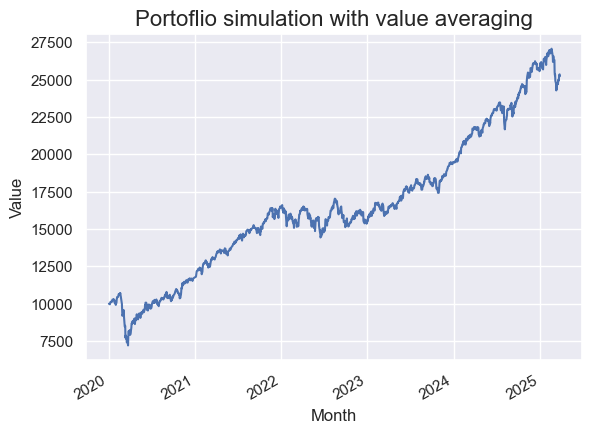

In [ ]:
df_VWCE_ordered['Investment Value'].plot(kind='line')
plt.title("Portoflio simulation with value averaging", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Value", fontsize=12)

In [ ]:
#Now some statistics! Sharpe ratio, ROI and CAGR

#CAGR
num_rows = len(df_VWCE_ordered)
CAGR=((df_VWCE_ordered['Investment Value'].iloc[-1]/initial_investment)**0.5)-1
print(CAGR)

0.5890123954786568


In [ ]:
#Return on investment
total_investment=initial_investment+monthly_investment*len(df_VWCE_ordered)
ROI=(df_VWCE_ordered['Investment Value'].iloc[-1]-total_investment)/total_investment*100
print(ROI) #38% of ROI in 2 years! Good one

-82.40445719174342


In [ ]:
#Monthly sharpe ratio

mean_return = df_VWCE_ordered['Change %'].mean()
std_deviation = df_VWCE_ordered['Change %'].std()
risk_free_rate = 0.00001 #As hypotesis i use German Bund: 2.5%-year
sharpe_ratio_giornaliero = (mean_return - risk_free_rate) / std_deviation
sharpe_ratio_annualized = sharpe_ratio_giornaliero * np.sqrt(252*5)
print(sharpe_ratio_annualized)

#This sharpe ratio suggests we are in a bull market, the stock market performs well even though Bonds have been high cause of BCE and FED interest rate to fight inflation

1.5121854194844953
